**Installing necessary libraries**

In [1]:
#%pip install sweetviz
%pip install py-AutoClean
#%pip install PyMySQL
#%pip install sqlalchemy
#%pip install clusteval
#%pip install feature_engine
#%pip install pandas
#%pip install numpy
#%pip install seaborn
#%pip install sklearn
#%pip install scipy

Note: you may need to restart the kernel to use updated packages.


**Importing necessary functions**

In [2]:

import pandas as pd
import numpy as np
from feature_engine.outliers import winsorizer
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz
from AutoClean import *
from sklearn.pipeline import make_pipeline
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from clusteval import clusteval
from sqlalchemy import create_engine
from sklearn.preprocessing import OneHotEncoder, RobustScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster


c:\Users\kkama\OneDrive\Desktop\python\New folder\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Step 1: Data preparation**
    

**Creating connection between database and notebook**

In [7]:
user = 'user12'
pw = '##'
host = '127.0.0.1'
port = 3306
database = 'Global_air_travel'
 
def get_connection():
    return create_engine(
        url="mysql+pymysql://{0}:{1}@{2}:{3}/{4}".format(
            user, pw, host, port, database
        )
    )
 
 
if __name__ == '__main__':
 
    try:
       
        # GET THE CONNECTION OBJECT (ENGINE) FOR THE DATABASE
        engine = get_connection()
        print(
            f"Connection to the {host} for user {user} created successfully.")
    except Exception as ex:
        print("Connection could not be made due to the following error: \n", ex)

Connection to the 127.0.0.1 for user user1 created successfully.


In [10]:
import pymysql
#%pip install cryptography
db= 'Global_air_travel'
conn = pymysql.connect(host=host, user=user, password=pw)
cur = conn.cursor()
cur.execute(f"CREATE DATABASE IF NOT EXISTS {db}")
cur.close()
conn.close()


In [13]:
df = pd.read_csv(r'c:\Users\kkama\OneDrive\Desktop\360 digitmg\Ml\Assign 2\Data Set (3)\Data Set (5)\AirTraffic_Passenger_Statistics.csv')
df.to_sql('air_traffic', con=engine, if_exists='replace', index=False)


15007

In [14]:
sql_query = 'select * from air_traffic'
df1 = pd.read_sql_query(sql_query, engine)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15007 entries, 0 to 15006
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Activity Period              15007 non-null  int64 
 1   Operating Airline            15007 non-null  object
 2   Operating Airline IATA Code  14953 non-null  object
 3   GEO Region                   15007 non-null  object
 4   Terminal                     15007 non-null  object
 5   Boarding Area                15007 non-null  object
 6   Passenger Count              15007 non-null  int64 
 7   Year                         15007 non-null  int64 
 8   Month                        15007 non-null  object
dtypes: int64(3), object(6)
memory usage: 1.0+ MB


**Step 2: Exploratory data analysis**

**Dropping unwanted columns**

In [15]:
df1.drop(['Activity Period', 'Operating Airline IATA Code'] , axis=1, inplace= True)

**Auto eda using sweetviz library**

In [16]:
import warnings

try:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
        my_report = sweetviz.analyze([df1, 'df1'])
        my_report.show_html('report_air_travel.html')
except Exception as e:
    print(f"Ignored exception: {e}")



Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


Report report_air_travel.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


<Axes: >

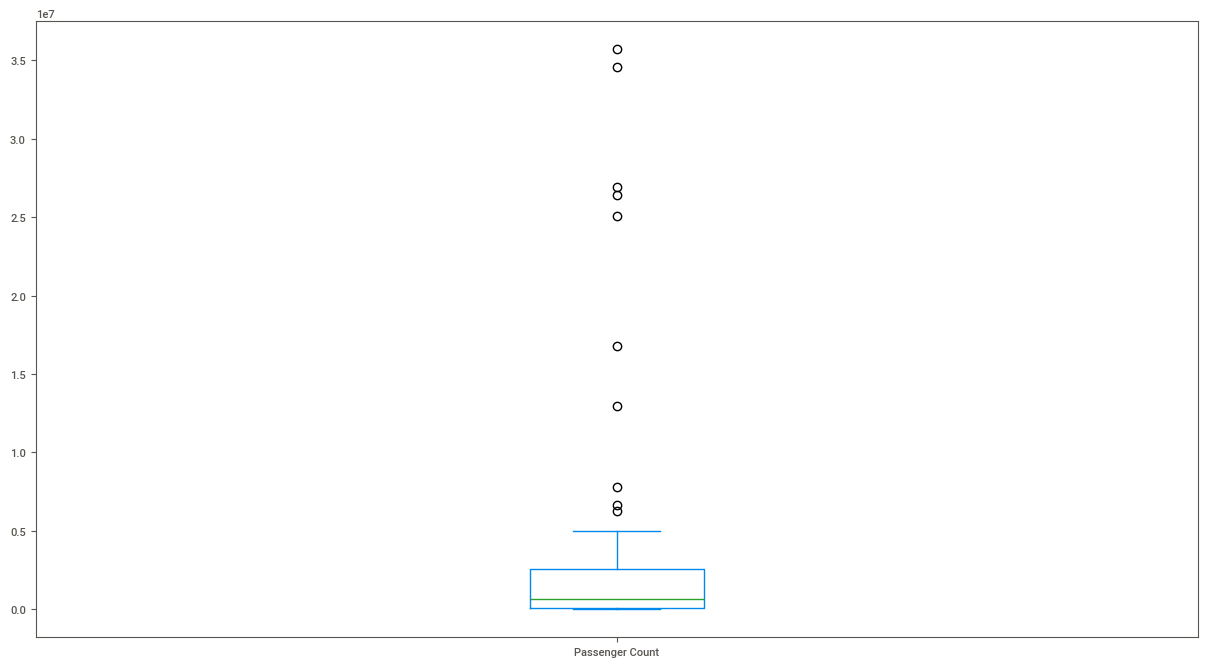

In [18]:
df3['Passenger Count'].plot(kind = 'box', figsize= (15,8))

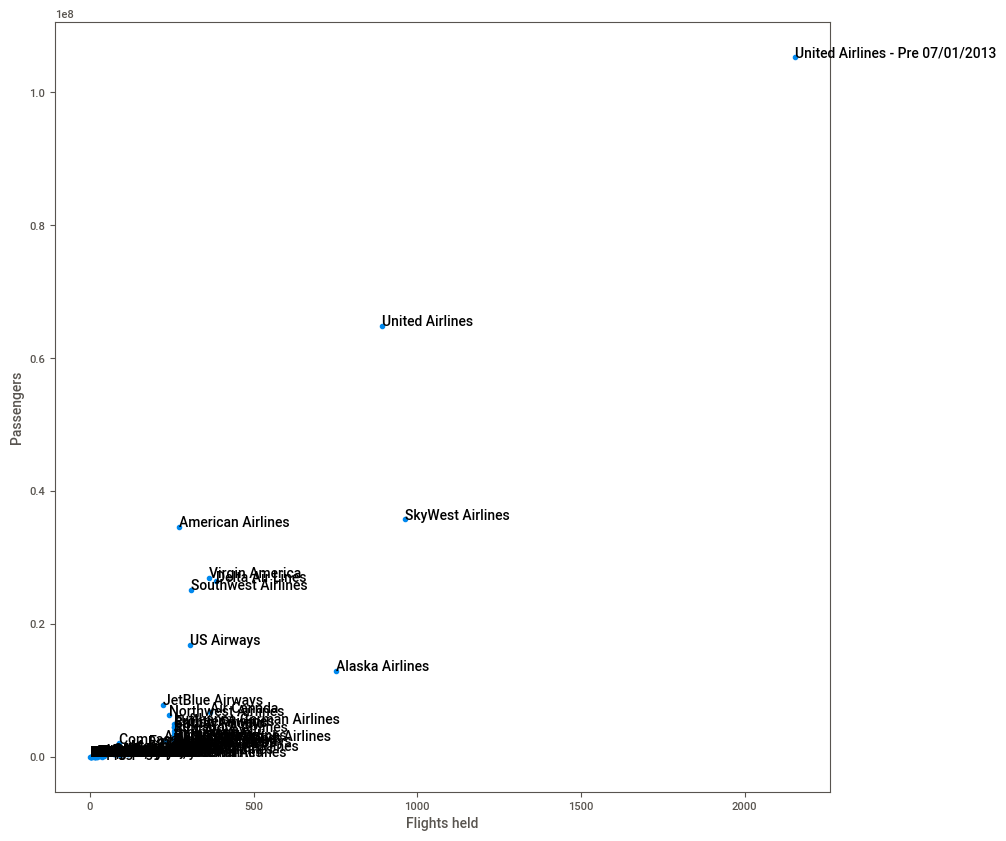

In [32]:
df1 = df[["Operating Airline", 'Boarding Area', "GEO Region", "Passenger Count", 'Month', 'Year']]

airline_count = df1["Operating Airline"].value_counts()
airline_count.sort_index(inplace=True)

passenger_count = df1.groupby("Operating Airline").sum()["Passenger Count"]
passenger_count.sort_index(inplace=True)

'''So as this algorithms is working with distances it is very sensitive to outliers, 
that’s why before doing cluster analysis we have to identify outliers and remove them from the dataset. 
In order to find outliers more accurately, we will build the scatter plot.'''

df2 = pd.concat([airline_count, passenger_count], axis=1)
# x = airline_count.values
# y = passenger_count.values
plt.figure(figsize = (10,10))
plt.scatter(df2['count'], df2['Passenger Count'])
plt.xlabel("Flights held")
plt.ylabel("Passengers")
for i, txt in enumerate(airline_count.index.values):
    a = plt.gca()
    plt.annotate(txt, (df2['count'][i], df2['Passenger Count'][i]))
plt.show()

df2.index
# We can see that most of the airlines are grouped together in the bottom left part of the plot, 
# some are above them, and it has 2 outliers United Airlines and Unites Airlines — Pre 07/01/2013.
# So let’s get rid of them.

# Drop specific airlines from the dataset
df1 = df1[~df1['Operating Airline'].isin(['United Airlines', 'United Airlines - Pre 07/01/2013'])]


In [33]:
df1

,Operating Airline,Boarding Area,GEO Region,Passenger Count,Month,Year
0,ATA Airlines,B,US,27271,July,2005
1,ATA Airlines,B,US,29131,July,2005
2,ATA Airlines,B,US,5415,July,2005
3,Air Canada,B,Canada,35156,July,2005
4,Air Canada,B,Canada,34090,July,2005
...,...,...,...,...,...,...
15002,Virgin America,D,US,194636,March,2016
15003,Virgin America,A,Mexico,4189,March,2016
15004,Virgin America,D,Mexico,4693,March,2016
15005,Virgin Atlantic,A,Europe,12313,March,2016


**Step 3: Data cleaning**

**Data cleaning using autoclean library**


Mapping month feature for applying cyclic transformation

In [34]:
month_map = {
    'January': 1, 'Jan': 1,
    'February': 2, 'Feb': 2,
    'March': 3, 'Mar': 3,
    'April': 4, 'Apr': 4,
    'May': 5,
    'June': 6, 'Jun': 6,
    'July': 7, 'Jul': 7,
    'August': 8, 'Aug': 8,
    'September': 9, 'Sep': 9,
    'October': 10, 'Oct': 10,
    'November': 11, 'Nov': 11,
    'December': 12, 'Dec': 12
}

df1['Month'] = df1['Month'].map(month_map)


**Step 4: Model building **

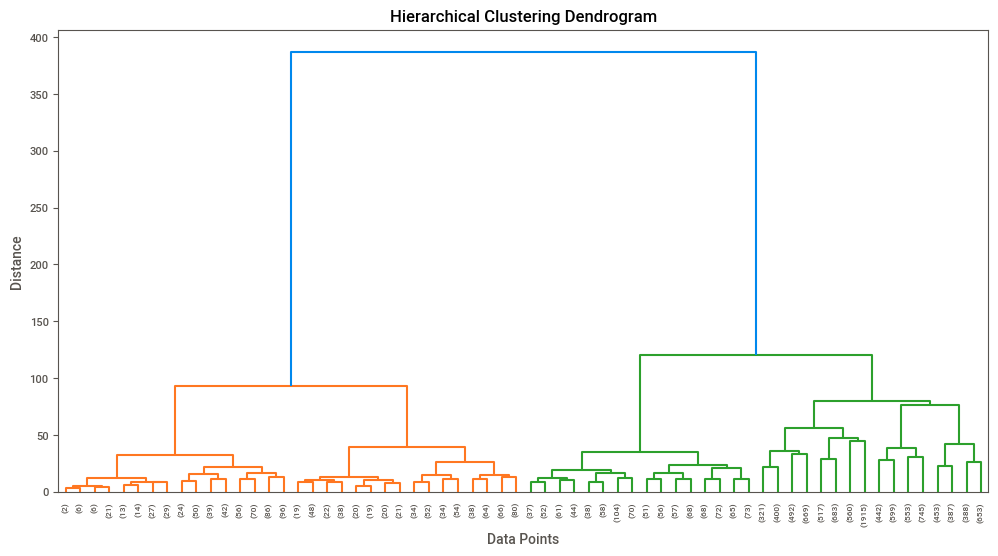

In [81]:

df1['Month'] = pd.to_numeric(df1['Month'])
df1['Passenger Count'] = pd.to_numeric(df1['Passenger Count'])
# --- Transform Month using sine-cosine (cyclic) encoding
def cyclic_month(X):
    month = pd.to_numeric(X['Month'], errors='coerce')
    return pd.DataFrame({
        'month_sin': np.sin(2 * np.pi * month / 12),
        'month_cos': np.cos(2 * np.pi * month / 12)
    })

# --- Set up transformers
log_transform = FunctionTransformer(np.log1p, validate=False)
cyclic_transform = FunctionTransformer(cyclic_month, validate=False)

from sklearn.preprocessing import StandardScaler
num_transform1 = Pipeline([
    ('log', log_transform),   
    ('scale', StandardScaler())
])
from sklearn.preprocessing import MinMaxScaler
num_transform2 = Pipeline([
    ('log', log_transform),
    ('scale', MinMaxScaler())
])
from sklearn.preprocessing import QuantileTransformer
num_transform3 = Pipeline([
    ('log', log_transform),
    ('scale', QuantileTransformer(output_distribution='uniform'))
])
num_transform4 = Pipeline([
    ('scale', RobustScaler())
])
num_transform5 = Pipeline([
    ('scale', StandardScaler())
])

# --- Select columns
cat_cols = [ 'Boarding Area',  'GEO Region']  
num_cols = ['Passenger Count', 'Year']

# --- Preprocessing
preprocessor = ColumnTransformer([
    ('num', num_transform4, ['Passenger Count', 'Year']),
    ('cyclic_month', cyclic_transform, ['Month']),
    ('onehot', OneHotEncoder(drop='if_binary', sparse_output=False), cat_cols),
])

# --- Apply pipeline
X_transformed = preprocessor.fit_transform(df1)

# --- Perform hierarchical clustering
linkage_matrix = linkage(X_transformed, method='ward')  

# --- Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='level', p=5)  
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()



**Step 5: Model evaluation**

In [82]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

X_transformed = preprocessor.fit_transform(df1)

hc1 = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='complete')
cluster_labels = hc1.fit_predict(X_transformed)

df1['cluster'] = cluster_labels

score = silhouette_score(X_transformed, cluster_labels)
print("Silhouette Score:", score)


Silhouette Score: 0.6232534717239465


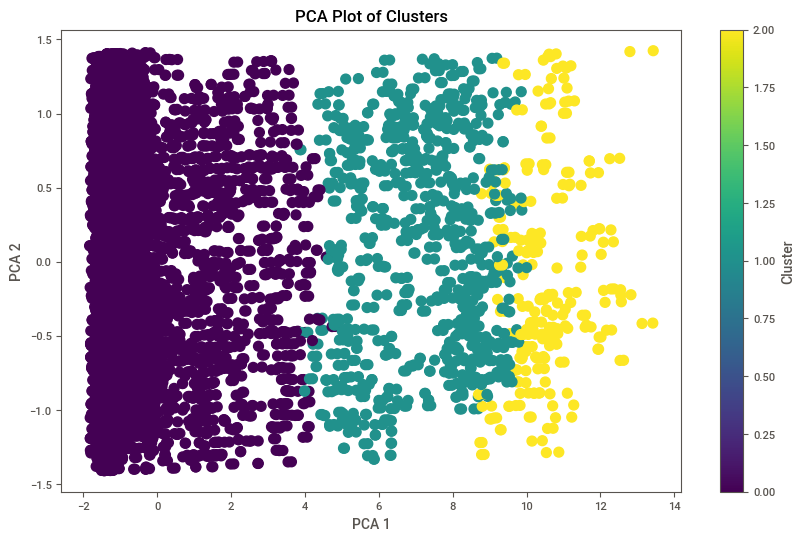

In [72]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced = pca.fit_transform(X_transformed)

plt.figure(figsize=(10,6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=df1['cluster'], cmap='viridis', s=50)
plt.title('PCA Plot of Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()


In [66]:
# Quick summary table
summary = df1.groupby('cluster').agg({
    'Passenger Count': ['mean', 'min', 'max'],
    'Operating Airline': pd.Series.nunique,
    'Boarding Area': pd.Series.nunique,
    'Year': pd.Series.nunique
}).rename(columns={
    'Operating Airline': 'Unique Airlines',
    'Boarding Area': 'Unique Boarding Areas',
    'Year': 'Years Covered'
})
summary.columns = ['_'.join(col) for col in summary.columns]
summary


,Passenger Count_mean,Passenger Count_min,Passenger Count_max,Unique Airlines_nunique,Unique Boarding Areas_nunique,Years Covered_nunique
cluster,,,,,,
0,12436.816895,1,87381,75,8,12
1,141829.140264,113706,194636,5,5,12
2,99418.060924,53953,135236,6,6,12


[clusteval] >INFO> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[clusteval] >INFO> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


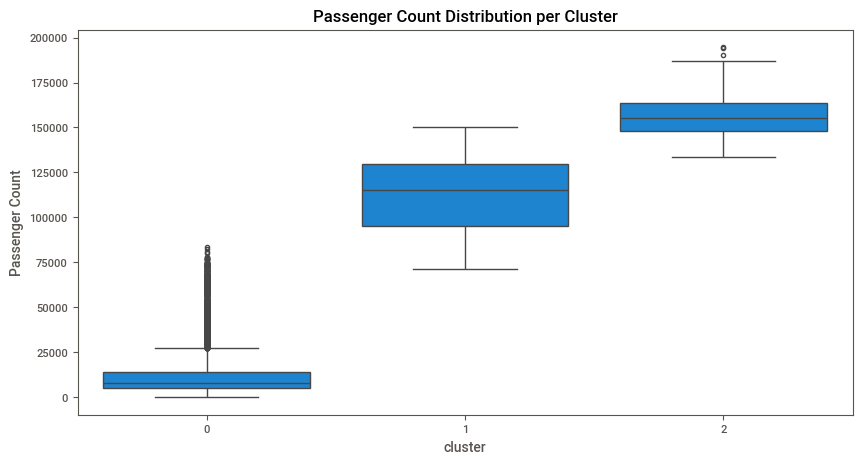

In [73]:

plt.figure(figsize=(10, 5))
sns.boxplot(x='cluster', y='Passenger Count', data=df1)
plt.title("Passenger Count Distribution per Cluster")
plt.show()


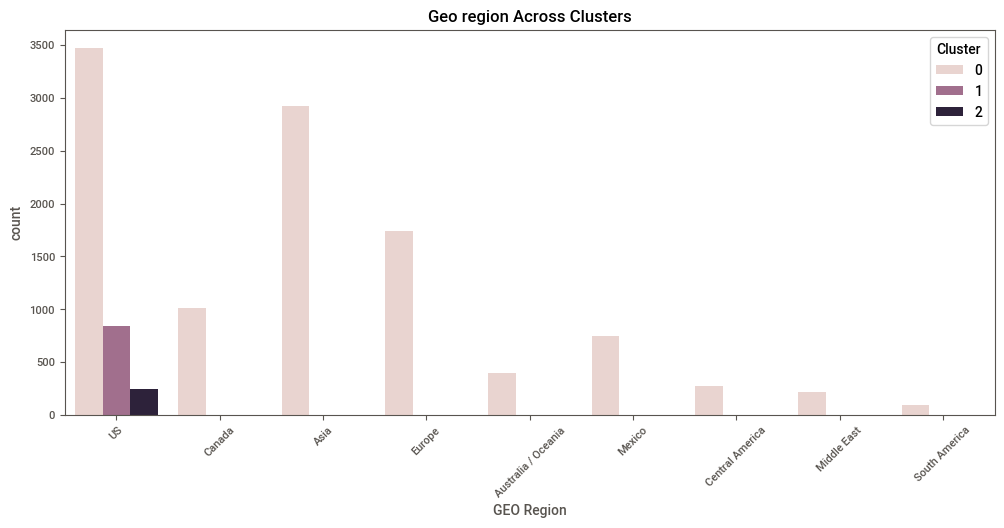

In [74]:
plt.figure(figsize=(12, 5))
sns.countplot(data=df1, x='GEO Region', hue='cluster')
plt.title("Geo region Across Clusters")
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.show()


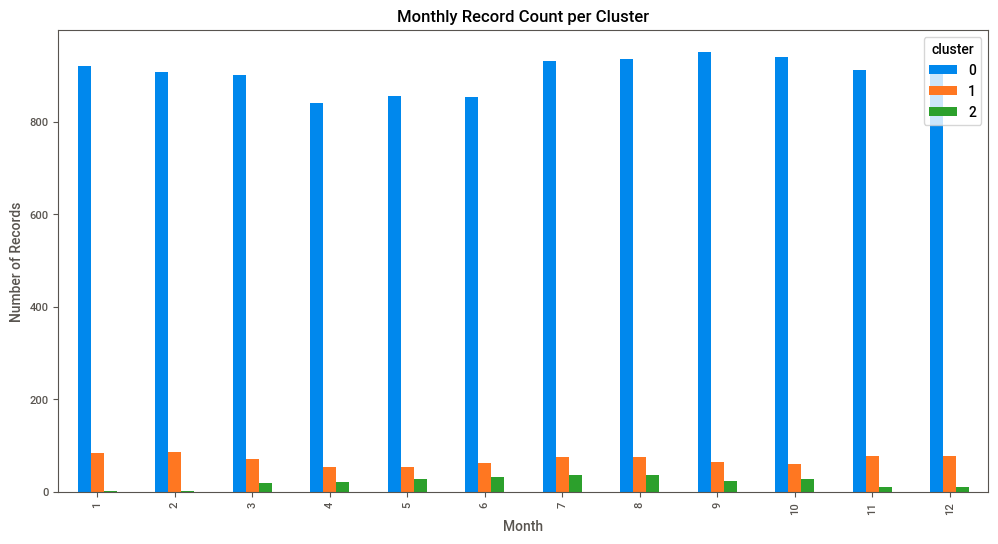

In [75]:
monthly_counts = df1.groupby(['cluster', 'Month']).size().unstack()
monthly_counts.T.plot(kind='bar', figsize=(12, 6))
plt.title('Monthly Record Count per Cluster')
plt.xlabel('Month')
plt.ylabel('Number of Records')
plt.show()


[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|██████████| 23/23 [00:45<00:00,  1.97s/it]
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [2].
[clusteval] >INFO> Fin.


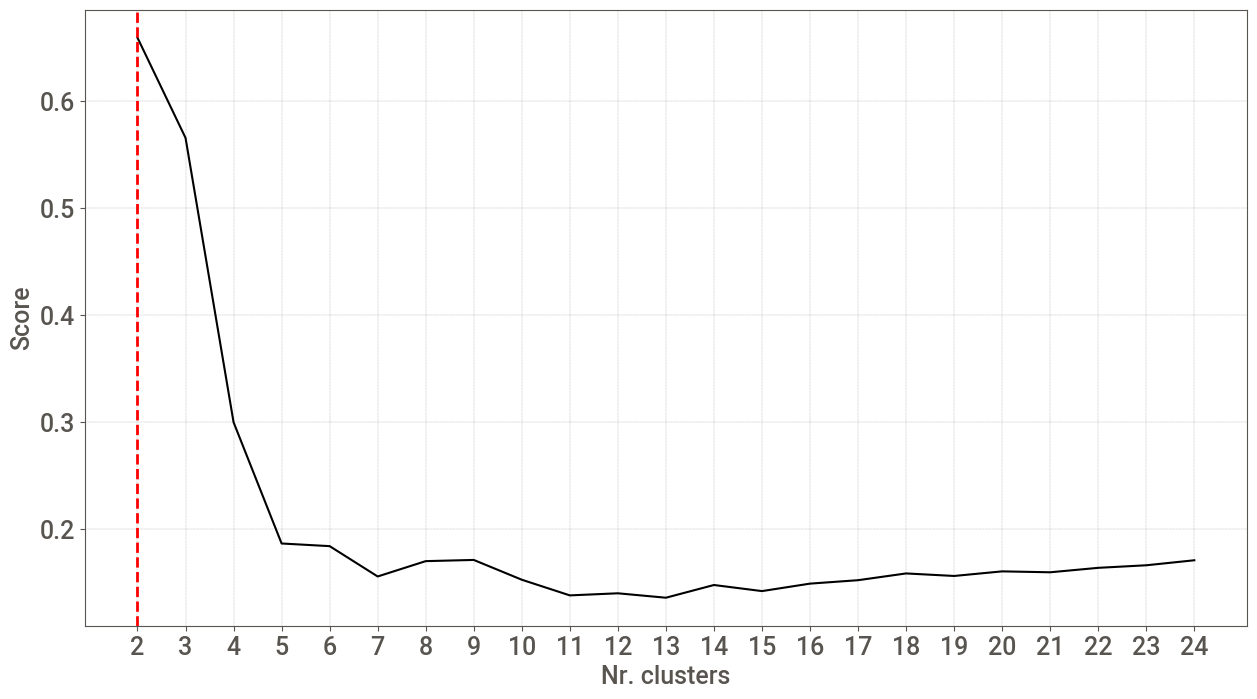

(<Figure size 1500x800 with 1 Axes>,
 <Axes: xlabel='Nr. clusters', ylabel='Score'>)

In [ ]:
ce = clusteval(evaluate= 'silhouette')
df_array = np.array(X_transformed)
ce.fit(df_array)
ce.plot()